In [1]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [2]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,45803,None,None,85806.769316
2020-06-13,45804,None,None,79697.102353
2020-06-14,45805,None,None,74031.104758
2020-06-15,45806,None,None,68692.704742
2020-06-16,45807,None,None,63935.557186
...,...,...,...,...
2021-04-05,46100,None,None,52790.598823
2021-04-06,46101,None,None,50281.300948
2021-04-07,46102,None,None,47810.200188


In [3]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-04-09_2021-04-09-17-25.pickle


In [4]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-04-08_2021-04-08-16-30.pickle


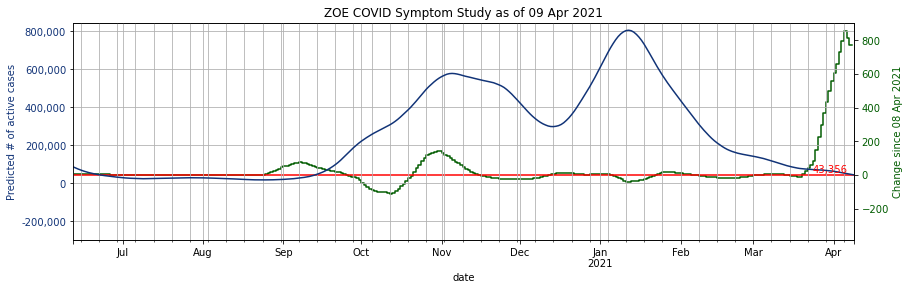

In [5]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

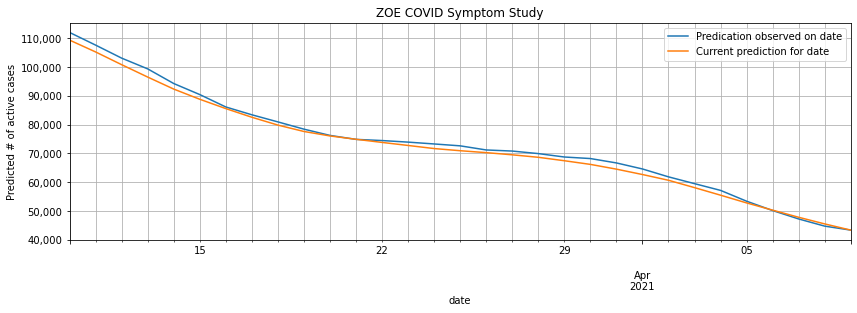

In [6]:
plot_study_evolution(curr_date, days=30)

In [7]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [8]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-04-09_2021-04-09-17-25.pickle


In [9]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
285,South Tyneside,E08000023,0.593059
146,Staffordshire Moorlands,E07000198,0.427156
122,Castle Point,E07000069,0.390605
376,South Lanarkshire,S12000029,0.379560
204,Selby,E07000169,0.205418
324,East Dunbartonshire,S12000045,0.195317
2,Redcar and Cleveland,E06000003,0.192483
286,Sunderland,E08000024,0.191133
197,South Norfolk,E07000149,0.179227
266,Bolton,E08000001,0.171989
